<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2022/11 $-$ CC BY-SA 4.0 $-$ </span>
<img src="img/cc_icon_white_x2.png" width="20" style="vertical-align: middle;">
<img src="img/attribution_icon_white_x2.png" width="20" style="vertical-align: middle;">
<img src="img/sa_white_x2.png" width="20" style="vertical-align: middle;">

# Machine learning avec les modules Python tensorflow2/keras :

# Entraînement / exploitation d'un réseau de neurones dense pour la reconnaissance de chiffres manuscrits

version 3.0 du 10 octobre 2022

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    Il est fondamental d'utiliser un <span style="font-weight:bold;">Environnement Virtuel Python</span> (EVP) pour chaque projet Python important : l'EVP permet de maîtriser pour chaque projet les versions de l'interpréteur Python et des modules "sensibles" (comme tensorflow par exemple).</span></div>

Les <i>notebooks</i> de l'APP-ML doivent être chargés dans un processus `jupyter notebook` lancé dans l'EVP <b><span style="color: rgb(200, 51, 102);">minfo_ml</span></b> créé en suivant la procédure du document `Consignes.pdf`. Ils doivent être travaillés dans l'ordre :

- `ML1_MNIST.ipynb` : vérifier le bon fonctionnement de l’EVP <b><span style="color: rgb(200, 51, 102);">minfo_ml</span></b>, charger et utiliser les données de la banque MNIST (images et labels).
- `ML2_DNN.ipynb` : construire un réseau dense, l’entraîner avec les données de la banque MNIST et afficher ses performances.
- `ML3_DNN_suite.ipynb` : charger un réseau dense entraîné et l’exploiter avec les données de test  MNIST.

**Le notebook `ML1_MNIST.ipynb` doit être travaillé avant celui-ci.**

## Objectifs d'apprentissage visés :
- Savoir construire un réseau de neurones dense avec les modules Python **tensorflow** et **keras**.
- Savoir entraîner un réseau dense avec les données de la banque MNIST.
- Savoir afficher les courbes de performance de l'entraînement.
- Savoir sauvegarder la strucure et les poids du réseau entraîné.

## Import des modules Python
Le module **keras** qui permet une manipulation de haut niveau des objets **tensorflow** est intégré dans le module **tensorflow** (tf) depuis la version 2. <br>
La documentation du module **tf.keras** à consulter pour cet APP est ici : https://www.tensorflow.org/api_docs/python/tf/keras. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
import matplotlib.pyplot as plt
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

2022-11-03 16:04:16.475833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 16:04:16.475853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Python    : 3.8.13
tensorflow: 2.8.0 incluant keras 2.8.0
numpy     : 1.21.2


Incrustation des tracés matplotlib dans le notebook et import de modules utiles :

In [2]:
%matplotlib inline

# Structure du réseau dense à construire 
Dans cette étape nous allons construire un **réseau dense**, avec :
- une **couche d'entrée** de 784 valeurs comprises entre 0 et 1 (les pixels des image MNIST 28 $\times$ 28 mis sous forme d'un vecteur de 784 nombres `float` normalisés),
- une **couche cachée** de 784 neurones utilisant la fonction d'activation `relu`,
- une **couche de sortie** à 10 neurones, pour la classification des images en 10 classes associées aux chiffres {0,1,2...9}, utilisant la fonction d'activation `softmax` adaptée aux problèmes de classification.

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/archiReseau.png" alt="archiReseau.png" style="width: 900px;"><br> 
    [crédit image : JLC]
</p>

Remarques : 
- Chaque neurone de la première couche cachée reçoit 785 entrées : les 784 valeurs $x_i$ des pixels de l'image plus le biais. 
- $\leadsto$ Il y a donc 785 inconnues pour chaque neurone : les 784 poids $w_i$ affectés à chaque entrée $x_i$, plus le  poids $b$ affecté à l'entrée $-1$.
- $\leadsto$ on compte donc 785 $\times$ 784 inconnues pour la couche cachée et 785 $\times$ 10 inconnues pour la couche de sortie : soit un total de 623290 inconnues dont la valeur doit être optimisée par l'algorithme d'apprentissage du réseau.

## Travail à faire
### 1 - Charger les images MNIST et définir les paramètres importants<br>2 - Pré-traiter les images et labels MNIST<br>3 - Construire du réseau de neurones<br>4 - Un premier essai d'entraînement du réseau<br>5 - Entraîner le réseau en mesurant ses performances à chaque *epoch*<br>6 - Entraîner le réseau en mesurant ses performances à chaque *epoch* avec gestion de l'*over-fit*<br>7 - Sauvegarder le réseau entraîné


## 1 - Charger les images MNIST et définir les paramètres importants

Le travail de chargement des images MNIST a été traité dans le *notebook* `ML1_MNIST.ipynb` :

In [3]:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()
print("im_train -> shape:", im_train.shape, ", dtype:", im_train.dtype,)
print("im_test  -> shape:", im_test.shape,  ", dtype:", im_test.dtype,)
print("lab_train-> shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("lab_test -> shape:", lab_test.shape,  ", dtype:", lab_test.dtype)

im_train -> shape: (60000, 28, 28) , dtype: uint8
im_test  -> shape: (10000, 28, 28) , dtype: uint8
lab_train-> shape: (60000,) , dtype: uint8
lab_test -> shape: (10000,) , dtype: uint8


#### Définir les paramètres importants

Pour éviter "d'écrire en dur" le **nombre d'images** d'entraînement et de test, la **dimension** des images et le **nombre de classes** à reconnaître, on récupère ces paramètres grâce aux attributs d'objets existants :
- l'attribut `shape` des tableaux `im_train` et `im_test` permet d'extraire le nombre d'images d'entraînement et de test,
- l'attribut `size` de la première image d'entraînement (ou de test) donne le nombre de pixel des images (784),<br>
- la transformation du tableau `lab_test` en un `set` Python (un ensemble) donne l'ensemble des labels à reconnaître, dont la taille est le nombre de classes.

Compléter la cellule ci-dessous :

In [4]:
nb_im_train = im_train.shape[0]    # nombre d'images d'entraînement
nb_im_test  = im_test.shape[0]     # nombre d'images de test 
nb_pixel    = im_train[0].size     # nombre d'éléments (des pixels) de la première image 
nb_classe   = len(set(lab_test))   # nombre de classe à identifier (les 10 chiffres de 0 à 9)

Vérification :

In [5]:
print(f"{nb_im_train} images d'entraînement et {nb_im_test} images de test")
print(f"{nb_pixel} pixels dans chaque image")
print(f"{nb_classe} classes à reconnaître (les chiffres de 0 à 9)")

60000 images d'entraînement et 10000 images de test
784 pixels dans chaque image
10 classes à reconnaître (les chiffres de 0 à 9)


## 2 - Pré-traiter les images et labels MNIST

Deux traitements doivent être appliqués sur les données de la banque MNIST :
- sur les images : transformer les matrice d'entiers `uint8` représentant les images 28$\,\times\,$28 pixels en vecteurs **normalisés** $(V_i)_{i=0..783}$ de 784 valeurs réelles $V_i$  avec $ 0 \leqslant V_i \leqslant 1$;
- sur les labels : transformer les nombres scalaires en vecteurs *one-hot*.

### Transformer les matrices d'entrée en vecteurs normalisés 

Définir les tableaux `x_train` et `x_test` contenant les matrices des tableaux `im_train` et `im_test` *mises à plat* sous forme de vecteurs normalisés (valeurs comprises entre 0 et 1).<br>
*indications* : 
- utiliser la méthode `reshape` des tableaux *ndarray* de *numpy* et les paramètres `nb_im_train`, `nb_im_test` et `nb_pixel` calculés précédemment,
- la normalisation peut être traitée en divisant les tableaux par leur valeur max.

In [6]:
x_train = im_train.reshape(nb_im_train, nb_pixel)/im_train.max()
x_test  = im_test.reshape(nb_im_test, nb_pixel)/im_test.max()

Vérifier les dimensions des tableaux `x_train` et `x_test` ainsi que leurs valeurs *min* et *max* :

In [7]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [8]:
(x_train.min(), x_train.max()) == (0, 1)

True

In [9]:
(x_test.min(), x_test.max()) == (0, 1)

True

###  Codage *one-hot*  des labels:

Consulter la documentation de la fonction `to_categorical` sur la page [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)  et en déduire comment définir les tableaux `y_train` et `y_test` contenant la version encodée *hot-one* des tableaux `lab_train` et `lab_test` :

In [10]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Vérifier visuellement les 10 premières valeurs des tableaux `lab_train` et `y_train` :

In [11]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 3 - Construire le réseau de neurones

On va maintenant construire un réseau de neurones **séquentiel** dense en **5 lignes** Python à l'aide du module **keras**.

Construire le réseau  de façon incrémentale dans la cellule ci-dessous, en suivant la démarche proposée (on pourra s'aider de la page [guide/keras/sequential_model](https://www.tensorflow.org/guide/keras/sequential_model) si besoin) :
- 1/ Créer l'objet `model` instance de la classe `Sequential` (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).
- 2/ Avec la méthode `add` de l'objet `model` ajouter :
    - la couche d'entrée `Input(shape=<nombre de neurones>)` (cf [tf.keras.layers.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input))<br>
    Utiliser le paramètre `nb_pixel` pour spécifier la valeur du paramètre `shape` (qui doit être un `tuple`)...<br>
    - la couche dense intermédiaire (cf [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) : `Dense(<nombre de neurones>, activation='relu')` (cf [tf.keras.activation.relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu))
    - la couche dense de sortie : `Dense(<nombre de neurones>, activation='softmax')` (cf [tf.keras.activation.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)).<br>
Utiliser les paramètres `nb_pixel` et `nb_classe` pour indiquer le nombre de neurones et le nombre de classes sans les 'écrire en dur'...    
- 3/ Une fois construit, le réseau doit être compilé (au sens de tensorflow) avec la méthode `compile` et les arguments :
    - `loss='categorical_crossentropy'` : choix de la fonction d'erreur (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
    - `optimizer='adam'` : choix de l'optimiseur Adam (cf page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))
    - `metrics=['accuracy']` pour obtenir les statistiques d'entraînement permettant de tracer les courbes de performance.

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model = Sequential()
model.add(Input(shape=(nb_pixel,), name='Input'))
model.add(Dense(nb_pixel, activation='relu', name='C1'))
model.add(Dense(nb_classe, activation='softmax', name='C2'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

2022-11-03 16:04:19.361735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-03 16:04:19.361761: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 16:04:19.361779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kong): /proc/driver/nvidia/version does not exist
2022-11-03 16:04:19.362251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


*Remarque* : en utilisant l'argument nommé `name` dans les constructeurs `Input` et `Dense`, on peut donner des noms personnalisés aux couches, qui apparaîtront dans les sorties de `summary` et de `plot_model`.

Avec la méthode `summary` de l'objet `model`, faire afficher la description du modèle et vérivhier les dimensions...

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 784)               615440    
                                                                 
 C2 (Dense)                  (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


Pourquoi y-a-t-il des `None` dans la colonne "Output Shape"  ?

Retrouver le nombre total de paramètres avec une formule simple ...

In [14]:
785*784+785*10

623290

La fonction `plot_model` permet de dessiner la structure du réseau (voir la page [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)).<br>
Faire tracer la structure du modèle en ajoutant l'option `show_shapes=True` à l'appel de `plot_model` :

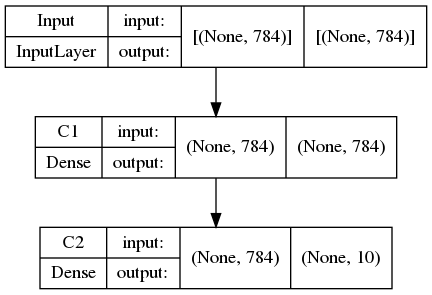

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Sauvegarder l'état initial du  réseau

On peut sauvegarder l'état initial des poids du réseau non-entraîné (valeurs aléatoires) avec la méthode `save_weights` de la classe `Sequential`. <br>
Ce sera utile plus loin pour remettre le réseau à son état initial avant de relancer d'autres entraînements :

In [16]:
import os

# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.isdir("weights"): os.mkdir("weights")

# sauvegarde des poinds du réseau initial:
key = 'dense1_init'
model.save_weights(os.path.join('weights', key))

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/dense1_init.data-00000-of-00001
weights/dense1_init.index


Remarque : la méthode `save_weights` utilise la partie `key` du chemin passé en argument pour préfixer les fichiers créés.<br>
Lors de la lecture ultérieure des poids du réseau avec la méthode `load_weights` de la classe `Sequential`, il suffira de donner la même clef pour retrouver les bons fichiers.

## 4 - Premier essai d'entraînement du réseau

Consulter au besoin la documentation de la méthode `fit` sur la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Compléter la cellule ci-dessous pour entraîner le réseau avec la méthode `fit` de l'objet `model` en utilisant les arguments :
- `x_train` : les 60000 images mises à plat et normalisées
- `y_train` : les 60000 labels encodés *one-hot*.
- `epochs=15` : faire 15 fois l'entraînement complet.
- `batch_size=128` : découper le jeu des données d'entrée (les 60000 images) en "lots" (*batch*) de taille `batch_size` (ici en lots de 128 images).<br>
La mise à jour des poids du réseau est faite par paquets de `batch_size` images.<br>
La valeur de `batch_size` (par défaut : 32) est un paramètre qui influe sur la qualité de l'apprentissage mais aussi sur son empreinte mémoire : on pourra plus loin essayer différentes valeurs (64, 128, 256 ...) et observer comment évolue la qualité de l'entraînement).

In [17]:
# au cas on on exécute plusieurs fois cette cellule, on peut ré-initialiser 
# le réseau à son état initial si on veut comparer les entraînements...
key = 'dense1_init'
model.load_weights(os.path.join('weights', key)) 

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2479 - accuracy: 0.9292
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0981 - accuracy: 0.9712
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0616 - accuracy: 0.9818
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0430 - accuracy: 0.9872
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0305 - accuracy: 0.9911
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0219 - accuracy: 0.9938
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0154 - accuracy: 0.9963
Epoch 8/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0114 - accuracy: 0.9971
Epoch 9/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0095 - accuracy: 0.9977
Epoch 10/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0078 - accuracy: 0.9981

L'objet `hist` retourné par la méthode `fit` possède un attribut `history` de type `dict` dont les clefs `'loss'` et `'accuracy'` sont associées aux informations correspondantes obtenues après chaque _epoch_ :

In [18]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

In [19]:
hist.history['loss']

[0.24794550240039825,
 0.09809277206659317,
 0.061607666313648224,
 0.04299036040902138,
 0.030524563044309616,
 0.02185109443962574,
 0.015408381819725037,
 0.01143721118569374,
 0.009477878920733929,
 0.007791872601956129,
 0.006682214327156544,
 0.00984165072441101,
 0.006851619109511375,
 0.0032837926410138607,
 0.005042443983256817]

In [20]:
hist.history['accuracy']

[0.9292333126068115,
 0.9712333083152771,
 0.9817666411399841,
 0.9871500134468079,
 0.9910500049591064,
 0.9937999844551086,
 0.9962666630744934,
 0.9971166849136353,
 0.9976500272750854,
 0.998116672039032,
 0.9982666373252869,
 0.9968166947364807,
 0.9978333115577698,
 0.9993500113487244,
 0.9984666705131531]

### Tracé des courbes `loss` et `accuracy` 

La fonction `plot_loss_accuracy` du module `utils.tools` (présent dans le répertoire du notebook) permet de tracer les courbes "Model accuracy" et "Model loss" sur la base des données stockées dans `hist`.<br> Importer et utiliser la fonction`plot_loss_accuracy` pour faire tracer ces courbes :

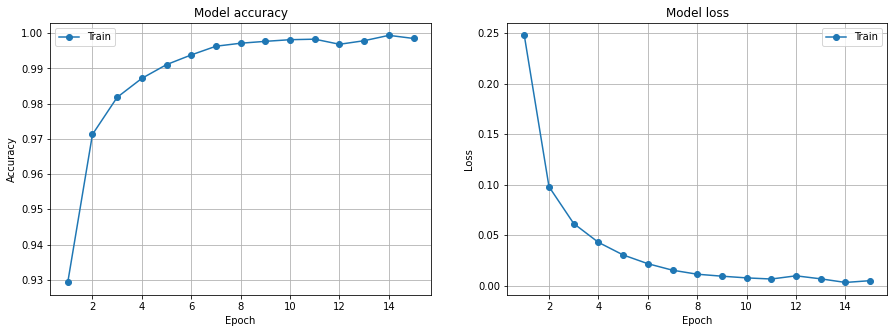

In [21]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 5 - Entraîner le réseau en mesurant ses performances à chaque *epoch*

Pour avoir un indicateur réaliste de la qualité du réseau entraîné on peut tester à chaque `epoch` la précison des inférences du réseau entraîné en utilisant les données de test : il suffit de passer l'argument `validation_data` à la méthode `fit`, en lui affectant le tuple des données de test `(x_test, y_test)`

In [22]:
# recharger l'état initial du réseau:
key = 'dense1_init'
model.load_weights(os.path.join('weights', key))

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=15, 
                 batch_size=128)

Epoch 1/15
469/469 [==============================] - 2s 5ms/step - loss: 0.1943 - accuracy: 0.9424 - val_loss: 0.0964 - val_accuracy: 0.9702
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0717 - accuracy: 0.9786 - val_loss: 0.0735 - val_accuracy: 0.9772
Epoch 3/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0442 - accuracy: 0.9873 - val_loss: 0.0636 - val_accuracy: 0.9801
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.0609 - val_accuracy: 0.9803
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0589 - val_accuracy: 0.9812
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0545 - val_accuracy: 0.9828
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 

On a cette fois dans `hist.history` non seulement les clefs `loss` et `accuracy` mais aussi `val_loss` et `val_accuracy` calculées avec les données de test :

In [23]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Faire afficher ces courbes avec la fonction `plot_loss_accuracy` :

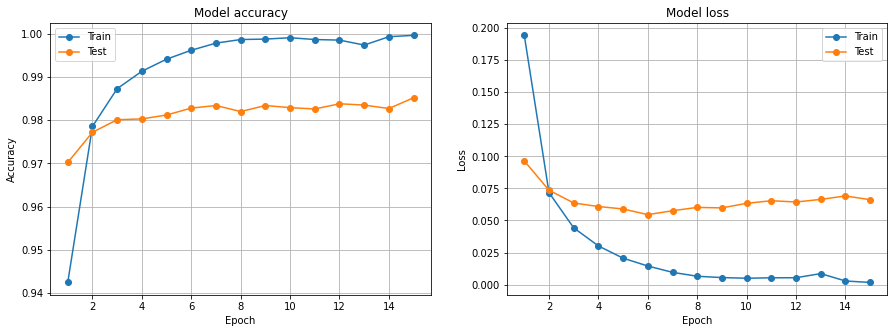

In [24]:
plot_loss_accuracy(hist)

la précision calculée avec les données de test tend vers une limite voisine de 98%. On pourrait penser qu'augmenter la valeur de `epochs` permet d'améliorer la précision du réseau... mais on court le risque de sur-entraîner le réseau (*over-fit*).

## 6 - Entraîner le réseau en mesurant ses performances à chaque *epoch* avec gestion de l'*over-fit*

Le module `Keras`  propose des outils pour arrêter automatiquement l'apprentissage en surveillant par exemple la croissance de la précision d'une `epoch` à l'autre.
Le mécanisme consiste à définir les paramètres du *callback* `EarlyStopping` (cf [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) et de le passer à la méthode `fit` via l'argument nommé `callbacks` :

Epoch 1/15
469/469 [==============================] - 2s 5ms/step - loss: 0.1887 - accuracy: 0.9439 - val_loss: 0.0945 - val_accuracy: 0.9700
Epoch 2/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0678 - accuracy: 0.9799 - val_loss: 0.0710 - val_accuracy: 0.9777
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0412 - accuracy: 0.9880 - val_loss: 0.0609 - val_accuracy: 0.9811
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0280 - accuracy: 0.9916 - val_loss: 0.0603 - val_accuracy: 0.9811
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0552 - val_accuracy: 0.9815
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.0544 - val_accuracy: 0.9826
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0565 - val_accuracy: 0.9834
Epoch 

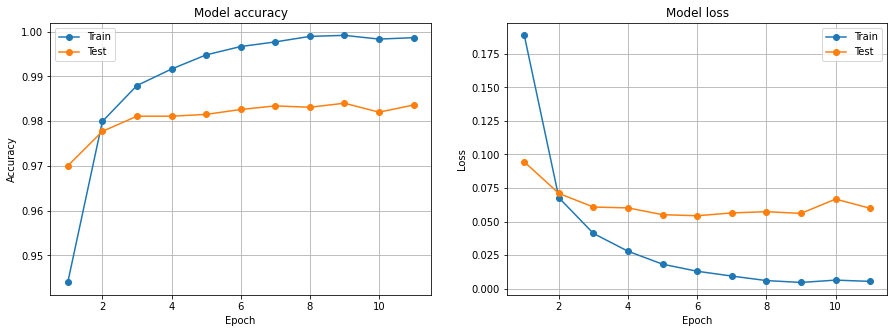

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_accuracy',  # la grandeur à surveiller
                  patience=2,              # accepter que 'val_accuracy' diminue 2 fois en tout
                  mode='max',              # arrêter si le paramètre décroît 
                  restore_best_weights=True,
                  verbose=1)
]

# recharger l'état initial du réseau:
key = 'dense1_init'
model.load_weights(os.path.join('weights', key))

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Au lieu de surveiller la croissance du paramètre `val_accuracy`, on peut aussi surveiller la décroissance de `val_loss` :

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1917 - accuracy: 0.9437 - val_loss: 0.0961 - val_accuracy: 0.9708
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0702 - accuracy: 0.9789 - val_loss: 0.0719 - val_accuracy: 0.9781
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0428 - accuracy: 0.9876 - val_loss: 0.0623 - val_accuracy: 0.9805
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0289 - accuracy: 0.9916 - val_loss: 0.0620 - val_accuracy: 0.9799
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0569 - val_accuracy: 0.9822
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0137 - accuracy: 0.9966 - val_loss: 0.0556 - val_accuracy: 0.9826
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0570 - val_accuracy: 0.9833
Epoch 

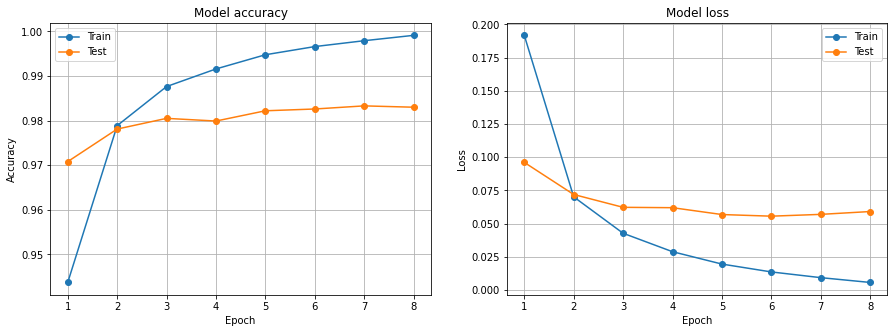

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',  # la grandeur à surveiller
                  patience=2,          # accepter que 'val_accuracy' diminue 2 fois en tout
                  mode='min',          # arrêter si le paramètre croît 
                  restore_best_weights=True,
                  verbose=1)
]

# recharger l'état initial du réseau:
key = 'dense1_init'
model.load_weights(os.path.join('weights', key))

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 8 - Sauvegarder le réseau entraîné

On peut sauvegarder dans un fichier les **poids** ou **la structure et les poids** d'un réseau entraîné avec les méthodes `save_weights` et `save` de la classe `Sequential`.<br><br>

### Sauvegarder les poids du réseau entraîné :

In [27]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poids du réseau entrainé:
key = 'trained1_data'
model.save_weights(os.path.join('weights', key))

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/trained1_data.index
weights/trained1_data.data-00000-of-00001


### Sauvegarder les poids du réseau entraîné et sa structure

La méthode `save` de la classe `Sequential` permet d'enregistrer dans des fichiers **la structure et les poids** du réseau entraïné<br>
Ceci permet de recréer plus tard *from scratch* le réseau entrainé pour passer en phase d'exploitation du réseau par exemple, en utilisant la fonction`tf.keras.models.load_model` :

In [28]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
key = 'trained1_model'
model.save(os.path.join('models', key) )

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

2022-11-03 16:05:59.315097: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/trained1_model/assets


INFO:tensorflow:Assets written to: models/trained1_model/assets


models/trained1_model


### Suite :

Tu peux maintenant charger le notebook `ML3_DNN_suite.ipynb` pour apprendre à exploiter le réseau de neurones dense que tu viens d'entraîner.

## Autres ressources intéressantes... des vidéos :

In [29]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [30]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [31]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [32]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>